# Exploration of the Milano TelCom data

In this notebook, we explore and visualize a few aspects of the data for "Milano" (intensity of telcom by square) and "Milano to Milano" (network of communication) files.

This was also used to validate some preprocessing steps, useful to our further work. 
In particular, the first section is about extracting all the information for a single square, without forgetting the absent lines (meaning a zero intensity of communication for those timestamps)


##  1. A few visualisations on the Milano files

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from src.preprocess_tools import *
import os

In [18]:
file = 'data/MI-2013-11-04_processed.csv'
# file = 'data/Example_of_processed_MI_file.txt'
d = pd.read_csv(file, sep = '\t')
# d.columns = ['Square','Time','Country','SMSin','SMSout','Callin','Callout','Internet', "Month","Day","Hour","WDay","Charge"]
d.drop("Time",axis=1,inplace=True)
d.set_index(["Square","Month","Day","WDay","Hour"],inplace=True)
d.head(5)

Country     SMSin    SMSout    Callin   Callout  \
Square Month Day WDay Hour                                                    
1      11    3   6    23          0  0.108039  0.000000  0.000000  0.000000   
                      23         39  0.026137  0.030875  0.026137  0.055225   
                      23         39  0.187075  0.106876  0.027300  0.000000   
                      23         39  0.027925  0.027925  0.001787  0.054601   
                      23         39  0.190564  0.106876  0.000000  0.026137   

                            Internet  Charge  
Square Month Day WDay Hour                    
1      11    3   6    23    0.000000       0  
                      23    9.260190       0  
                      23    9.215273       1  
                      23    8.669007       0  
                      23    7.811099       1

### 1. Intensity by hour during a day

/home/cgaydon/Ressources/anaconda3/envs/MilanoKeras/lib/python3.5/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


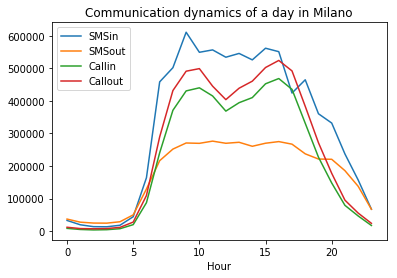

In [19]:
dHour = d.groupby(level = ["Hour"]).sum()
dHour.plot(y = ["SMSin","SMSout","Callin","Callout"], title = "Communication dynamics of a day in Milano")

/home/cgaydon/Ressources/anaconda3/envs/MilanoKeras/lib/python3.5/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


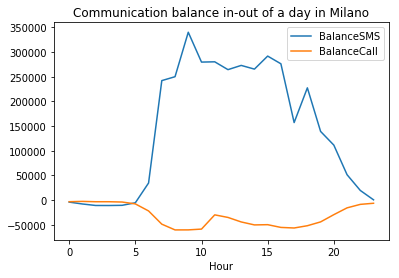

In [20]:
dHour["BalanceSMS"] = dHour["SMSin"]- dHour["SMSout"]
dHour["BalanceCall"] =  dHour["Callin"]- dHour["Callout"]
#dHour.head
dHour.plot(y = ["BalanceSMS","BalanceCall"], use_index=True, title = "Communication balance in-out of a day in Milano")

If the data is considered exhaustive, would this means that Milano's inhabitant mostly sms outside of their city, and are called from outside ?

### Intensity by hour during a week

later : we need to load seven different txt files into one to get this, as a file = a day... 

TODO : preprocess all MI files without header, stack them, add header, and save.

### 2. Intensity by square

In [21]:
dSquare = d.groupby(level = ["Square"]).sum()
dSquare.reset_index("Square",inplace=True)
dSquare['j'] = dSquare["Square"]%100
dSquare['i'] = ((dSquare["Square"]-dSquare["j"])/100).apply(lambda x : int(x))
dSquare.head()

Square  Country       SMSin     SMSout     Callin    Callout     Internet  \
0       1    27198  104.793806  54.821018  67.898464  70.399418  1404.813593   
1       2    27198  106.562510  55.662914  68.918439  71.517368  1411.031972   
2       3    23555  108.445224  56.559079  70.004163  72.707383  1417.651191   
3       4    27198   99.670726  52.382451  64.944086  67.161253  1386.801946   
4       5    27281   92.949668  48.663776  60.665410  63.114114  1269.014143   

   Charge  j  i  
0     162  1  0  
1     168  2  0  
2     168  3  0  
3     157  4  0  
4     146  5  0

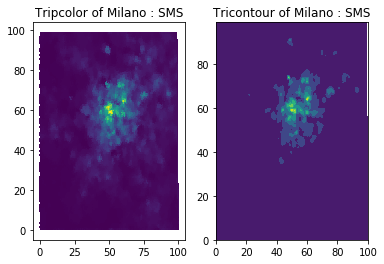

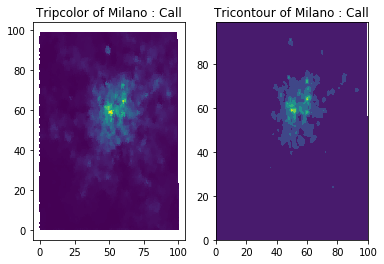

In [22]:
dSquare["SMS"] = dSquare["SMSin"]+dSquare["SMSout"]
dSquare["Call"] = dSquare["Callin"] + dSquare["Callout"]
for label in ["SMS","Call"]:
    fig, (ax, ax2)=plt.subplots(ncols=2)
    ax.set_title("Tripcolor of Milano : "+label)
    ax.tripcolor(dSquare["i"], dSquare["j"], dSquare[label])
    ax2.set_title("Tricontour of Milano : " +label)
    ax2.tricontourf(dSquare["i"], dSquare["j"], dSquare[label])

    plt.show()

## 2. Understanding how to manipulate Milano to Milano files

In [26]:
file = 'data/MItoMI-2013-12-01.txt'
verbose = True
d = pd.read_csv(file, sep = '\t',header=None)
if verbose:
    print("Read : " +file)

d.columns = ['Time','Id1','Id2','Signal']

Read : data/MItoMI-2013-12-01.txt


In [27]:
mask = np.logical_and(d['Id1'].apply(keep_a_square),d['Id2'].apply(keep_a_square))

if verbose:
    print("Kept standard squares.")
d = d[mask]
d.fillna(0)
t = pd.DataFrame(data=d['Time'].apply(unix_to_ints))
if verbose:
    print("Time conversion.")
d['Month'] = t["Time"].apply(lambda x : x[0])
#d['Day'] = t["Time"].apply(lambda x : x[1])
d['Hour'] = t["Time"].apply(lambda x : x[2])
# d['WDay'] = t["Time"].apply(lambda x : x[3])

Kept standard squares.
Time conversion.


In [28]:
dPow = d
# dPow.drop(["Month","Time"],inplace=True,axis=1)
dPow = dPow.set_index(["Id1", "Id2","Hour"])
dPow = d.groupby(["Id1", "Id2","Hour",]).sum()
dPow.reset_index(["Hour"],inplace=True)


In [32]:
dPow.head(5)

Hour           Time        Signal  Month
Id1  Id2                                           
1520 1520     1  1385860800000  1.973093e-05     12
     1520     7  1385883600000  1.712988e-07     12
     1520     8  5543545800000  1.122429e-04     48
     1520     9  8315339400000  1.703310e-04     72
     1520    10  4157681400000  6.757199e-06     36

In [ ]:
# dPow.pivot(columns="Hour",values="Signal")
# dPow.reindex(labels = np.arange(24)+1)

In [ ]:
# dPow.reset_index(["Id1", "Id2"],inplace=True)

In [ ]:
# d.to_csv(path_or_buf = fileout, sep = '\t', index = False)
# print("Saved to : "+ fileout)

## 3. Understanding how to process a square in order to apply redictive Machine Learning techniques

In [ ]:
ori_path = "MI_data/"
next_path = "5560"
original_dir = os.listdir(ori_path)
next_dir = os.listdir(next_path)

for index,file_ori in enumerate(original_dir):
    print("["+str(index+1)+"/"+str(len(original_dir))+"]")
    file_target = next_path + "/"+next_path+"_"+file_ori
    if next_path+"_"+file_ori not in next_dir:
        geo_filter_a_MI(ori_path+file_ori,file_target)

In [ ]:
d = pd.DataFrame()
next_path = "5560"
next_dir = os.listdir(next_path)
ori_path = "Sample_data/MI_November/"
if next_path+"_all.csv" not in next_dir:
    for file in next_dir:
        if file != next_path+"_all.csv":
            sub = pd.read_csv(next_path+"/"+file,sep="\t")
            print(sub.shape)
            d = pd.concat([d,sub])
d.to_csv(next_path+'/'+next_path+"_all.csv", index = False,sep="\t")

# III. Learning on preprocessed MI data

In [ ]:
file = 'data/MI_squares/5560/5560_all.csv'
d = pd.read_csv(file, sep = '\t')
d.head(2)

### a) Basés sur []() nous transformons les TS pour un usage supervisé.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
file = 'data/MI_squares/5560/5560_all.csv'
dataset = pd.read_csv(file, sep = '\t')
dataset.drop("Square",axis=1,inplace=True)
dataset.set_index("Time",inplace=True)
values = dataset.values
# # integer encode direction
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict (i.e. hour, etc)
last_col = reframed.shape[1]-1
reframed.drop(reframed.columns[[last_col,last_col-1,last_col-2,last_col-3,last_col-4]], axis=1, inplace=True)
reframed.head()

### b) On divise en jeu train et jeu validation 

In [ ]:
values = reframed.values
n_ten_min = int((6*24*60)*0.85) #85% vs 15% 
train = values[:n_ten_min, :]
test = values[n_ten_min:, :]
# split into input and outputs
train_X, train_y = train[:, :-5], train[:, -5:]
test_X, test_y = test[:, :-5], test[:, -5:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

In [ ]:
values = reframed.values
n_ten_min = int((6*24*60)*0.85) #85% vs 15% 
train = values[:n_ten_min, :]
test = values[n_ten_min:, :]
# split into input and outputs
train_X, train_y = train[:, :-5], train[:, -5:]
test_X, test_y = test[:, :-5], test[:, -5:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((1,train_X.shape[0], train_X.shape[1]))
test_X = test_X.reshape((1,test_X.shape[0], test_X.shape[1]))

train_y = train_y.reshape((1,train_y.shape[0], train_y.shape[1]))
test_y = test_y.reshape((1,test_y.shape[0], test_y.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

### c) On importe keras, définissons notre architecture et entraînons le modèle

In [ ]:
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# design network
model = Sequential()
model.add(LSTM(80, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(5))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=100, validation_data=(test_X, test_y), verbose=2, shuffle=False)

In [ ]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### d) Evaluation du modèle

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
forecast = []
ground_truth = []
for index, name in enumerate(dataset.columns[:5]):   
    yhat = model.predict(test_X)
    test_X_reshaped = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    #forecast
    inv_yhat = np.concatenate((yhat,test_X_reshaped[:,5:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,index]
    forecast.append(inv_yhat)
    #ground truth
    inv_y = np.concatenate((test_y, test_X_reshaped[:, 5:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,index]
    ground_truth.append(inv_y)
    # calculate RMSE
    rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
    mae = mean_absolute_error(inv_y,inv_yhat)
    print(name +' - RMSE=%.3f and MAE=%.3f' % (rmse,mae))

### e) Visualisation

In [ ]:
# reframed.plot(y = reframed.columns[-5:])
# reframed.columns
# n_ten_min
# dataset.values[["SMSin","SMSout","Callin","Callout","Internet"]]
ground_train = dataset[["SMSin","SMSout","Callin","Callout","Internet"]].values[:n_ten_min,:]
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(np.arange(train_y.shape[0]),ground_train[:,4])
plt.plot(np.arange(train_y.shape[0],train_y.shape[0]+inv_yhat.shape[0]),inv_yhat)
plt.plot(np.arange(train_y.shape[0],train_y.shape[0]+inv_yhat.shape[0]),inv_y)